In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy
import matplotlib.pyplot as plt
import numpy as np
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalMaxPool1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Download data

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
wili_data_path = data_path + 'wili-2018/'

x_train_path = wili_data_path + 'x_train.txt'
x_test_path = wili_data_path + 'x_test.txt'
y_train_path = wili_data_path + 'y_train.txt'
y_test_path = wili_data_path + 'y_test.txt'
labels_path = wili_data_path + 'labels.csv'

In [115]:
labels = pd.read_csv(labels_path, sep=';')
labels = labels.drop(labels=['German', 'Writing system', 'Remarks', 'Synonyms'], axis=1)
labels

,Label,English,Wiki Code,ISO 369-3,Language family
0,ace,Achinese,ace,ace,Austronesian
1,afr,Afrikaans,af,afr,Indo-European
2,als,Alemannic German,als,gsw,Indo-European
3,amh,Amharic,am,amh,Afro-Asiatic
4,ang,Old English,ang,ang,Indo-European
...,...,...,...,...,...
230,yid,Yiddish,yi,yid,Indo-European
231,yor,Yoruba,yo,yor,Niger-Congo
232,zea,Zeeuws,zea,zea,Indo-European
233,zh-yue,Cantonese,zh-yue,NaN,Sino-Tibetan


In [0]:
# convert title of language in class
with open(y_train_path) as f:
    mylist = f.read().splitlines() 
languages = list(set(mylist))
language_to_class = dict()
class_to_language = dict()
for i in range(len(languages)):
    language_to_class[languages[i]] = i
    class_to_language[i] = languages[i]

In [8]:
print(list(language_to_class.items())[:5])
len(languages)

[('nep', 0), ('est', 1), ('vie', 2), ('pam', 3), ('csb', 4)]


235

In [0]:
def read_data():
    with open(x_train_path) as f:
        mylist = f.read().splitlines() 
    x_train = pd.DataFrame(mylist, columns=["sent"])
    with open(x_test_path) as f:
        mylist = f.read().splitlines() 
    x_test = pd.DataFrame(mylist, columns=["sent"])

    with open(y_train_path) as f:
        mylist = f.read().splitlines() 
    y_train = []
    for lan in mylist:
        y_train.append(language_to_class[lan])
    y_train = pd.DataFrame(y_train)
    with open(y_test_path) as f:
        mylist = f.read().splitlines()

    y_test = []
    for lan in mylist:
        y_test.append(language_to_class[lan])
    y_test = pd.DataFrame(y_test)
    
    return (x_train, y_train), (x_test, y_test)

In [0]:
(x_train, y_train), (x_test, y_test) = read_data()

In [11]:
print(x_train.head())
print(y_train.head())

print(x_train.shape)
print(x_test.shape)

                                                sent
0  Klement Gottwaldi surnukeha palsameeriti ning ...
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...
3  Après lo cort periòde d'establiment a Basilèa,...
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...
     0
0    1
1  140
2  170
3  210
4   28
(117500, 1)
(117500, 1)


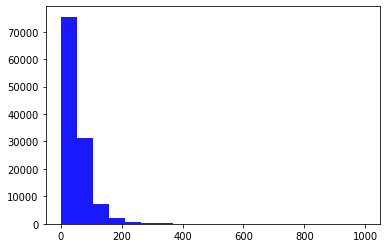

In [12]:
lens = x_train.sent.str.split(' ').str.len().values
plt.hist(lens, bins=np.linspace(0,1000,20), facecolor='blue', alpha=0.9)
plt.show()

# Experiment on small dataset

In [0]:
# small_dataset = pd.read_csv(data_path + 'kaggle_dataset/dataset.csv')
# small_dataset

In [0]:
# X=small_dataset['Text']
# y=small_dataset['language']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(len(X_train))
# print(len(X_test))
# print(len(y_train))
# print(len(y_test))

# Embedding **data**

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
tokenizer = Tokenizer(filters=filter_out, lower=True)
tokenizer.fit_on_texts(x_train.sent)

Выбираю какое количество слов оставить. Если оставлять все, то будет 1500000, что слишком много. Можно поменять `count` и оно покажет сколько слов встречается больше, чем `count` раз

In [32]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
frequent_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(frequent_words)

64157

In [0]:
embed_size = 300 # how big is each word vector
max_features = len(frequent_words) # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters=filter_out, lower=True)

def prepare_data():
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1, stratify=y_train.values)
   
    tokenizer.fit_on_texts(x_tr.sent)

    train_X = tokenizer.texts_to_sequences(x_tr.sent)
    val_X = tokenizer.texts_to_sequences(x_val.sent)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)

    return (train_X, y_tr), (val_X, y_val)
    

In [0]:
(train_X, train_Y), (val_X, val_Y) = prepare_data()

Проверила, что в тренировочном и валидационном датасетах встречаются все классы. Балансировка регулируется вот этим параметром: stratify=y_train.values

In [35]:
len(set(val_Y.values.reshape(1, -1)[0]))

235

In [0]:
len(set(train_Y.values.reshape(1, -1)[0]))

235

Ниже меняю представление векторов ответов из [1, 23, 10,...] в вектор длины 235 и с 1 на месте соответсвующего языка

In [59]:
lb = LabelEncoder()
y = lb.fit_transform(train_Y.values)
dummy_y_train = to_categorical(y)
print(len(dummy_y_train))
print(len(dummy_y_train[0]))

105750
235


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
y = lb.fit_transform(val_Y.values)
dummy_y_val = to_categorical(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Metrics

In [0]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [0]:
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

#CNN

In [49]:
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, embed_size,input_shape=(maxlen,)))
cnn_model.add(Conv1D(256, 5, activation='relu', input_shape=(embed_size,)))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(languages), activation='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          19247100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 256)          384256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)             

In [0]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
cnn_cp_path = data_path+'model_cnn.hdf5'
cnn_cp=ModelCheckpoint(cnn_cp_path, monitor='val_f1',save_best_only=True)

In [62]:
cnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=5, 
              validation_data=(val_X, dummy_y_val),
              callbacks = [cnn_cp])

Epoch 1/5
207/207 [==============================] - 87s 418ms/step - loss: 3.2681 - accuracy: 0.3020 - f1: 0.2766 - recall: 0.2162 - precision: 0.6018 - val_loss: 0.7261 - val_accuracy: 0.8397 - val_f1: 0.8468 - val_recall: 0.7590 - val_precision: 0.9581
Epoch 2/5
207/207 [==============================] - 86s 414ms/step - loss: 0.5337 - accuracy: 0.8660 - f1: 0.8820 - recall: 0.8239 - precision: 0.9495 - val_loss: 0.4821 - val_accuracy: 0.8918 - val_f1: 0.9104 - val_recall: 0.8615 - val_precision: 0.9651
Epoch 3/5
207/207 [==============================] - 85s 413ms/step - loss: 0.2602 - accuracy: 0.9291 - f1: 0.9427 - recall: 0.9112 - precision: 0.9765 - val_loss: 0.4964 - val_accuracy: 0.8921 - val_f1: 0.9114 - val_recall: 0.8736 - val_precision: 0.9528
Epoch 4/5
207/207 [==============================] - 86s 413ms/step - loss: 0.1830 - accuracy: 0.9478 - f1: 0.9589 - recall: 0.9353 - precision: 0.9838 - val_loss: 0.5692 - val_accuracy: 0.8871 - val_f1: 0.9085 - val_recall: 0.8762 

#RNN

In [63]:
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, embed_size))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh',input_dim=embed_size)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh')))
rnn_model.add(GlobalMaxPool1D())
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(512, activation="relu"))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(len(languages), activation='softmax'))
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         19247100  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1140736   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [0]:
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])

In [0]:
rnn_cp_path = data_path + 'model_rnn.hdf5'
rnn_cp=ModelCheckpoint(rnn_cp_path,monitor='val_f1',save_best_only=True)

In [66]:
rnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=3, 
              validation_data=(val_X, dummy_y_val), callbacks = [rnn_cp])

Epoch 1/3
207/207 [==============================] - 321s 2s/step - loss: 2.5891 - accuracy: 0.4243 - f1: 0.3768 - recall: 0.3188 - precision: 0.5763 - val_loss: 0.5165 - val_accuracy: 0.8675 - val_f1: 0.8854 - val_recall: 0.8305 - val_precision: 0.9481
Epoch 2/3
207/207 [==============================] - 317s 2s/step - loss: 0.4045 - accuracy: 0.8951 - f1: 0.9097 - recall: 0.8678 - precision: 0.9561 - val_loss: 0.3988 - val_accuracy: 0.8985 - val_f1: 0.9145 - val_recall: 0.8762 - val_precision: 0.9565
Epoch 3/3
207/207 [==============================] - 317s 2s/step - loss: 0.2285 - accuracy: 0.9368 - f1: 0.9492 - recall: 0.9225 - precision: 0.9775 - val_loss: 0.3939 - val_accuracy: 0.9061 - val_f1: 0.9226 - val_recall: 0.8887 - val_precision: 0.9592


# Results

In [0]:
x_test['sc'] = y_test

In [0]:
# Be careful! Tokenizer and maxlen is taken from train dataset from 1st part
def convert(x):
    train_X = tokenizer.texts_to_sequences(x.sent)
    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    return train_X

In [0]:
def metr(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return precision, recall, f1_val

# Test

In [118]:
ps = []
rs = []
fs = []
for lan in range(len(languages)):
    x_t = x_test[x_test['sc'] == lan]
    x = convert(x_t)
    y = np.zeros((x.shape[0], len(languages)))
    y[:, lan] = 1
    y = y.astype('float32')
    y_pred = cnn_model.predict(x)
    p, r, f = metr(y, y_pred)
    ps.append(p.numpy())
    rs.append(r.numpy())
    fs.append(f.numpy())
    print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  nep precision:  0.90123457 recall:  0.876 f1:  0.88843805
language:  est precision:  0.8597701 recall:  0.748 f1:  0.79999995
language:  vie precision:  0.98993963 recall:  0.984 f1:  0.9869609
language:  pam precision:  0.9605809 recall:  0.926 f1:  0.9429734
language:  csb precision:  0.9122449 recall:  0.894 f1:  0.9030303
language:  gle precision:  0.9816701 recall:  0.964 f1:  0.9727547
language:  ava precision:  0.8496732 recall:  0.78 f1:  0.8133471
language:  fra precision:  0.80131006 recall:  0.734 f1:  0.7661795
language:  zh-yue precision:  0.47887325 recall:  0.068 f1:  0.1190893
language:  msa precision:  0.8178054 recall:  0.79 f1:  0.80366224
language:  ext precision:  0.9414226 recall:  0.9 f1:  0.92024535
language:  bre precision:  0.9757576 recall:  0.966 f1:  0.97085416
language:  lad precision:  0.89979124 recall:  0.862 f1:  0.88049024
language:  snd precision:  0.99597585 recall:  0.99 f1:  0.9929789
language:  sin precision:  0.9627329 recall:  0.93 f

In [0]:
raw_metrics = pd.DataFrame(
    {'precision': ps,
     'recall': rs,
     'f1': fs
    })

In [0]:
metrics = raw_metrics.rename(class_to_language, axis='index')

In [121]:
print(metrics.head())

     precision  recall        f1
nep   0.901235   0.876  0.888438
est   0.859770   0.748  0.800000
vie   0.989940   0.984  0.986961
pam   0.960581   0.926  0.942973
csb   0.912245   0.894  0.903030


In [142]:
bad_quality_metrics = metrics[metrics.f1 < 0.7]
bad_quality_metrics

,precision,recall,f1
zh-yue,0.478873,0.068,0.119089
tha,0.953069,0.528,0.679537
zho,0.343750,0.022,0.041353
hbs,0.647321,0.580,0.611814
jpn,0.840580,0.116,0.203866
hrv,0.500000,0.462,0.480249
bod,0.975309,0.158,0.271945
lzh,0.000000,0.000,0.000000
khm,0.807377,0.394,0.529570
wuu,0.000000,0.000,0.000000


In [143]:
bad_quality_langs = list(bad_quality_metrics.index)
bad_quality_labels = labels.loc[labels['Label'].isin(bad_quality_langs)]
bad_quality_labels

,Label,English,Wiki Code,ISO 369-3,Language family
22,bod,Tibetan,bo,bod,Sino-Tibetan
23,bos,Bosnian,bs,bos,Indo-European
73,hbs,Serbo-Croatian,sh,hbs,Indo-European
77,hrv,Croatian,hr,hrv,Indo-European
92,jpn,Japanese,ja,jpn,Japonic
99,khm,Central Khmer,km,khm,Austronesian
110,lao,Lao,lo,lao,Tai-Kadai
123,lzh,Literary Chinese,zh-classical,lzh,Sino-Tibetan
164,pcd,Picard,pcd,pcd,Indo-European
207,tha,Thai,th,tha,Tai-Kadai


In [152]:
print(x_train[x_train.sc == language_to_class['wuu']])
print(x_train[x_train.sc == language_to_class['lzh']])

                                                     sent   sc
19      UNC有得一只历史悠久个'诚信守则'。渠是由学堂个诚信法庭（Honor Court）来执行个...  162
276     武器，是人类为达到杀伤或者防御个目的制造个器械。武器从人类文明发展开始就有出现，之后，伴随战...  162
387     弗过，太后个信任是一方面，具体西班牙个政治局面又是另外一番情形：贵族对迭个外国人一点也无信任...  162
720     从12世纪挨末阶段开始，日本个统治权就转移到日本武士贵族个手里向。到13世纪，出身清和源氏个...  162
930     箇种毛病潜伏期一般勒7日天以内，病人一般表现为流感箇浪个症状，像发寒热，咳嗽，少痰，有种辰光...  162
...                                                   ...  ...
116805  Linux個低成本、強大個定制功能搭良好個移植性能，使得Linux來嵌入式系統方面也得到廣泛...  162
116947  余杭區勒拉杭嘉湖平原南端，西依天目山，南瀕錢塘江，是長江三角洲个圓心地。地理座標爲北緯30°...  162
117034  北師大是以京師大學堂師範專業做基礎，搭仔由北京個高校匯聚一批勒師範教育領域窮有聲望個名師組建...  162
117037  到清中期（約18世紀），傳奇開始衰微，向書齋文學轉化，彈詞卻逐步興盛起來了。出版之錢德蒼編个...  162
117257  摩嘉娜夺权计划失败后，带领奄奄一息个莫高絲逃出卡美洛特，徕萨温节夜里，摩嘉娜徕莫高絲个要求之...  162

[500 rows x 2 columns]
                                                     sent   sc
336     武漢市，亦稱以漢，乃中華鄂省之會，亦為七大都市於中華之中原也。方八千四百六十七公里，於西元二...  104
420     按黃帝為法，數有十等。及其用也，乃有三焉。十等者，謂「億、兆、京、垓、秭、壤、溝、澗、正、載...  104
1254    范蠡浮海出齊，變姓名，自謂鴟夷子皮，耕於海畔，